In [25]:
from problem import get_train_data, get_test_data, WeightedClassificationError
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf
from time import time
import pandas as pd
import math
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
videos_train, labels_train = get_train_data()

In [27]:
X_for_classifier= np.array(videos_train)
y_for_classifier= labels_train

In [28]:
videos_test, labels_test  = get_test_data()

In [29]:
Xtest_for_classifier = np.array(videos_test)
ytest_for_classifier = labels_test

In [30]:
from PIL import Image

def resize_frames(video):
    res=[]
    for frame in video:
        resized_img=Image.fromarray(frame).resize((224,224))
        res.append(np.array(resized_img))
    return np.array(res)

In [31]:
#function that gets all dataset
# 30 frames per video for 177 video = 2.65 gb !if considering each frame of float64
# as uint8 it takes 0.33 gb

def gen_videos(videolist):
    newvideos=[] # 177*30*250*250
    for video in videolist:
        reducedvideo= video.read_samples(video.frame_times[0:299:10])
        #CROP from 250 to 224
        reducedvideo=resize_frames(reducedvideo)    

        newvideos.append(reducedvideo)
    return newvideos

In [32]:
X_for_classifier= np.array(gen_videos(X_for_classifier))
X_for_classifier = np.repeat(X_for_classifier[...,np.newaxis], 3, -1)

X_for_classifier.shape

(177, 30, 224, 224, 3)

In [33]:
Xtest_for_classifier= np.array(gen_videos(Xtest_for_classifier))
Xtest_for_classifier = np.repeat(Xtest_for_classifier[...,np.newaxis], 3, -1)

Xtest_for_classifier.shape

(100, 30, 224, 224, 3)

In [34]:
def class_to_int(argument):
    switcher = {
        'A':0,
        'B':1,
        'C':2,
        'D':3,
        'E':4,
        'F':5,
        'G':6,
        'H':7,
    }
 
    # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(argument, "nothing")

def int_to_class(argument):
    switcher = {
        0:'A',
        1:'B',
        2:'C',
        3:'D',
        4:'E',
        5:'F',
        6:'G',
        7:'H',
    }
 
    # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(argument, "nothing")


func=np.vectorize(class_to_int)
#Train
train_labels=func(y_for_classifier)
#Test
test_labels=func(ytest_for_classifier)

In [59]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    print(data.shape)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    print(data.shape)
        
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
#plot_slices(6, 10, 128, 128, image[:, :, :60])

In [60]:
video= Xtest_for_classifier[0]
print(video.shape)
video=np.delete(video,[0,1],3) # deletes 2 dim from 3 column
print(video.shape)
video=np.squeeze(video) #squeezes last dim when =1
print(video.shape)
np.asarray(video).shape


(30, 224, 224, 3)
(30, 224, 224, 1)
(30, 224, 224)


(30, 224, 224)

(30, 224, 224)
(3, 10, 224, 224)


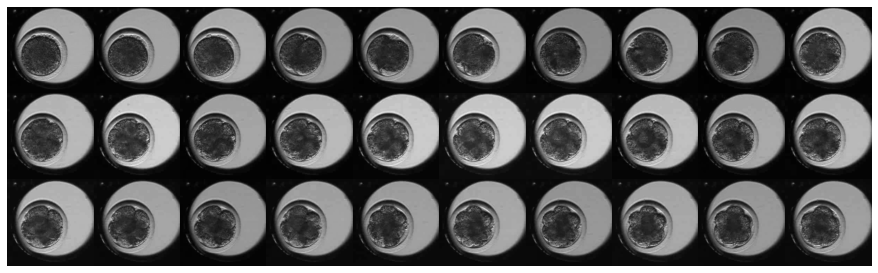

H


In [61]:
idx=0
plot_slices(3, 10, 224, 224, video)
print(int_to_class(train_labels[idx]))

## K Models

### Defining K models and K datasets of the Kth image

In [38]:
K=30

In [39]:
def build_model():
    # Image shape for classifier
    IMG_SHAPE = (224,224,3)

    # Building of a classification model
    base_model = tf.keras.applications.MobileNetV2(
            input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
        )
    base_model.trainable = False
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(8, activation="softmax")
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["sparse_categorical_accuracy"],
    )
    #model.summary()

    return model

In [40]:
m1= build_model()
#model.fit(X_for_classifier,y_for_classifier, epochs=100)

In [41]:
Kmodels=[]
# build 30 models
for i in range(K):
    Kmodels.append(build_model())

In [42]:
len(Kmodels)

30

In [43]:
X_for_classifier.shape

(177, 30, 224, 224, 3)

In [44]:
#gen 30 sub datasets with frames 
def gen_datasets():
    datasets=[]
    for i in range(K):
        dataset=[]
        for j in range (X_for_classifier.shape[0]):
            dataset.append(X_for_classifier[j,i,:,:])
        datasets.append(dataset)
    return datasets


In [45]:
Kdatasets= gen_datasets()

In [46]:
Kdatasets= np.array(Kdatasets)

In [47]:
np.array(Kdatasets).shape

(30, 177, 224, 224, 3)

In [49]:
Kmodels[0].fit(Kdatasets[0],train_labels,epochs=30)

Epoch 1/30
6/6 [==============================] - 4s 589ms/step - loss: 2.2005 - sparse_categorical_accuracy: 0.1638
Epoch 2/30
6/6 [==============================] - 3s 566ms/step - loss: 2.1397 - sparse_categorical_accuracy: 0.1921
Epoch 3/30
6/6 [==============================] - 4s 596ms/step - loss: 2.1678 - sparse_categorical_accuracy: 0.1921
Epoch 4/30
6/6 [==============================] - 4s 582ms/step - loss: 2.1233 - sparse_categorical_accuracy: 0.2034
Epoch 5/30
6/6 [==============================] - 4s 644ms/step - loss: 2.1243 - sparse_categorical_accuracy: 0.2090
Epoch 6/30
6/6 [==============================] - 5s 769ms/step - loss: 2.1166 - sparse_categorical_accuracy: 0.1921
Epoch 7/30
6/6 [==============================] - 4s 616ms/step - loss: 2.0088 - sparse_categorical_accuracy: 0.2316
Epoch 8/30
6/6 [==============================] - 4s 671ms/step - loss: 2.0952 - sparse_categorical_accuracy: 0.1864
Epoch 9/30
6/6 [==============================] - 3s 572ms/step 